# Napari image viewer

Uses the octopuslite dask image loader to automatically sort and load images from multichannel time lapse experiments. Can also use btrack to load associated tracks and segmentation images.

In [1]:
import napari
from octopuslite import DaskOctopusLiteLoader
import glob
import numpy as np

import numpy as np
from tqdm.auto import tqdm

def compute(dask_image_stack, N = None):
    
    """lazy hack to get around dask not loading transformed stacks in one go"""
    
    if N == None:
        N = (0, len(dask_image_stack) )
        
    return np.stack([frame.compute().astype(np.uint8) for frame in tqdm(dask_image_stack[N[0]:N[1]], total = N[1]-N[0])], axis = 0)

# Load images

In [8]:
# define experiment ID and select a position
expt = 'ND0025'
pos = 'Pos6'
# point to where the data is
root_dir = '/home/nathan/data/kraken/ras'
image_path = f'{root_dir}/{expt}/{pos}/{pos}_images'
transform_paths = glob.glob(f'{root_dir}/{expt}/{pos}/*.npy')
print(transform_paths)
tracks_path = f'{root_dir}/{expt}/{pos}/tracks_old.h5'

['/home/nathan/data/kraken/ras/ND0025/Pos6/transform_tensor.npy']


In [10]:
transform_path = transform_paths[0] #'/home/nathan/data/kraken/ras/ND0019/Pos2/mask_reversed_clipped_transform_tensor.npy'

In [11]:
# lazily load images
images = DaskOctopusLiteLoader(image_path,
                              transforms = transform_path,
                              crop = (1200,1600),
                              remove_background = True)
                              
images.channels

Using cropping: (1200, 1600)


[<Channels.BRIGHTFIELD: 0>,
 <Channels.GFP: 1>,
 <Channels.RFP: 2>,
 <Channels.IRFP: 3>,
 <Channels.MASK: 99>]

In [12]:
bf = images['brightfield']
gfp = images['gfp']
rfp = images['rfp']#.compute().astype(np.uint8)
irfp = images['irfp']
masks = images['mask']#.compute().astype(np.uint8)
#masks_old = images['mask_gfp']

### Add tracks

In [13]:
import btrack
from btrack.utils import tracks_to_napari

#### GFP tracks

In [14]:
with btrack.dataio.HDF5FileHandler(tracks_path, 
                                   'r', obj_type='obj_type_1'
                                  ) as h:
    gfp_tracks = h.tracks

In [15]:
gfp_tracks = [track for track in gfp_tracks if len(track)>20]# and track.fate.name == 'DIVIDE']

In [16]:
visualise_gfp_tracks, gfp_properties, gfp_graph = tracks_to_napari(gfp_tracks, ndim = 2)

#### RFP tracks

In [17]:
with btrack.dataio.HDF5FileHandler(tracks_path, 
                                   'r', obj_type='obj_type_2'
                                  ) as h:
    rfp_tracks = h.tracks

In [18]:
rfp_tracks = [track for track in rfp_tracks if len(track)>20]

In [19]:
visualise_rfp_tracks, rfp_properties, rfp_graph = tracks_to_napari(rfp_tracks, ndim = 2)

# Launch viewer

In [33]:
## number of frames to load
N = len(gfp)

In [34]:

viewer = napari.Viewer()
# viewer.add_image(bf[0:N].astype(np.uint8), name="bf", 
#                  contrast_limits=[0,255],
#                  blending = 'additive', )
viewer.add_image(gfp[0:N].astype(np.uint8), name=f"gfp {expt}{pos}", 
                 contrast_limits=[0,119],
                 blending = 'additive', colormap = 'green')#, is_pyramid=False)
viewer.add_image(rfp[0:N].astype(np.uint8), name="rfp", 
                 contrast_limits=[0,55], 
                 blending = 'additive', colormap = 'magenta')#, is_pyramid=False)
# viewer.add_image(irfp[0:N].astype(np.uint8), name="irfp", 
#                  contrast_limits=[0,255], 
#                  blending = 'additive', colormap = 'cyan')#
# viewer.add_labels(masks[0:N].astype(np.uint8), name = 'masks',
#                blending = 'additive',)
# viewer.add_labels(masks_2[0:N].astype(np.uint8), name = 'masks filt',
#                blending = 'additive',)
# viewer.add_labels(images['mask'].astype(np.uint8), name = 'masks original',
#                blending = 'additive',)
viewer.add_tracks(visualise_gfp_tracks, properties=gfp_properties,)# graph = gfp_graph)
viewer.add_tracks(visualise_rfp_tracks, properties=rfp_properties,)# graph = rfp_graph)

__init__.py (165): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


<Tracks layer 'visualise_rfp_tracks' at 0x7f2400c11f10>

# Inspecting the tracks

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [21]:
div_coords = [(track.x[-1], track.y[-1], track.t[-1]) for track in gfp_tracks if track.fate.name == 'DIVIDE']

In [22]:
div_coords

[(273.99432373046875, 623.0471801757812, 428),
 (1146.777099609375, 245.2549591064453, 22),
 (975.8670654296875, 34.8145751953125, 433),
 (884.7205200195312, 86.8567886352539, 594),
 (339.4003601074219, 142.7270050048828, 696),
 (957.8070068359375, 133.80874633789062, 228),
 (1302.1151123046875, 114.02838134765625, 360),
 (1530.3270263671875, 162.77674865722656, 514),
 (510.536865234375, 119.35005187988281, 399),
 (645.80712890625, 111.60527801513672, 465),
 (333.38665771484375, 131.4192657470703, 396),
 (1137.1611328125, 208.1503448486328, 581),
 (1238.3104248046875, 168.42922973632812, 452),
 (1488.4617919921875, 182.33663940429688, 368),
 (1556.0059814453125, 204.42735290527344, 494),
 (134.2399139404297, 356.3406677246094, 433),
 (1168.400390625, 366.1919250488281, 465),
 (79.84005737304688, 242.0773162841797, 491),
 (794.047607421875, 250.98646545410156, 345),
 (1505.712646484375, 280.0887756347656, 282),
 (1574.507080078125, 273.7084655761719, 399),
 (1039.8175048828125, 299.0393

In [23]:
df = pd.DataFrame(div_coords, columns=['x','y','t'])

In [31]:
df.loc[df['t']==968]

,x,y,t
214,954.25,1137.942749,968


/home/nathan/analysis/miniconda3/envs/cellx/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

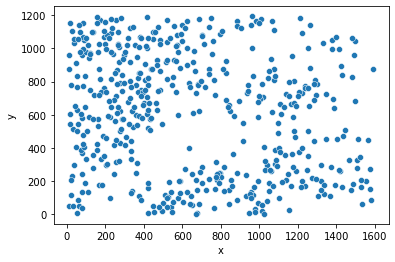

In [25]:
sns.scatterplot(df['x'], df['y'])

<AxesSubplot:xlabel='t', ylabel='Count'>

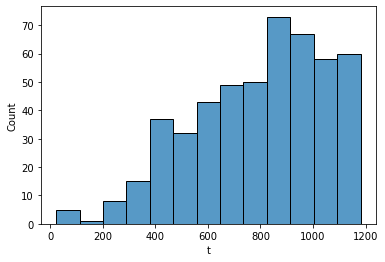

In [26]:
sns.histplot(df['t'])

inspecting extrusion track (t = 

In [27]:
extru = [track for track in rfp_tracks if track.ID == 1234][0]

In [28]:
extru

,ID,t,x,y,z,parent,root,state,generation,dummy,prob_apoptosis,mean_intensity,prob_prometaphase,area,eccentricity,prob_metaphase,prob_interphase,class id,prob_anaphase
0,1234,916,970.724243,940.406067,0.000000,1234,1234,0,0,False,0.017741,10.994972,1.917990e-03,482.0,0.655133,5.808974e-04,9.795460e-01,2.0,2.140949e-04
1,1234,917,972.070618,943.764099,0.000000,1234,1234,4,0,False,0.997623,12.538992,2.476691e-07,385.0,0.764780,2.551000e-07,2.376160e-03,2.0,2.496593e-07
2,1234,918,971.674377,941.478394,0.000000,1234,1234,4,0,False,0.995044,11.519631,4.696435e-05,613.0,0.542044,1.064847e-04,4.653564e-03,2.0,1.490460e-04
3,1234,919,986.766357,934.254639,0.000000,1234,1234,4,0,False,0.948983,10.780898,2.384819e-06,1852.0,0.831389,4.406359e-02,6.951229e-03,2.0,2.415773e-07
4,1234,920,993.602722,931.456055,0.000000,1234,1234,0,0,False,0.307435,11.039990,5.012442e-04,1404.0,0.846178,1.853005e-02,6.735052e-01,2.0,2.798935e-05
5,1234,921,997.566895,930.356079,0.000000,1234,1234,4,0,False,0.919029,11.784107,3.611606e-05,1456.0,0.835573,2.729675e-02,5.338410e-02,2.0,2.545240e-04
6,1234,922,991.718140,932.343994,0.000000,1234,1234,0,0,False,0.036266,10.857759,1.394351e-04,1929.0,0.859553,2.225543e-02,9.413387e-01,2.0,3.572848e-08
7,1234,923,996.519653,928.249268,0.000000,1234,1234,4,0,False,0.678457,11.518690,1.733166e-03,1519.0,0.746691,8.020532e-03,3.109150e-01,2.0,8.742011e-04
8,1234,924,997.583374,928.118225,0.000000,1234,1234,4,0,False,0.897046,11.804721,6.048370e-05,927.0,0.347989,2.068581e-04,1.026196e-01,2.0,6.681502e-05
9,1234,925,987.674500,929.197693,0.000000,1234,1234,4,0,False,0.994297,11.849230,1.379379e-05,1589.0,0.831148,5.444242e-03,2.395715e-04,2.0,5.953159e-06


# quick check to see if there is clustering of divisions +- couple hours from t=874 extrusion

In [37]:
divs = df.loc[(df['t'] < 874+15) & (df['t'] > 874-15)]

In [38]:
divs

,x,y,t
94,843.819458,61.680279,878
102,1180.294312,669.930969,888
181,621.644653,1162.725830,861
208,825.678040,850.783081,879
239,183.474686,179.331772,864
248,656.802002,916.012939,881
267,68.129097,1095.888184,887
269,1065.861694,613.927551,881
270,689.722656,254.121933,887
294,967.867249,830.442566,865


In [41]:
def euc_dist(x1, x2, y1, y2):
    
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [46]:
divs['tij'] = 0
divs['dij'] = 0
focal_t = 874
focal_x = 1005
focal_y = 995

for i, row in divs.iterrows():
    divs.at[i, 'tij'] = row['t'] - focal_t
    divs.at[i, 'dij']= euc_dist(row['x'], focal_x, row['y'], focal_y)

frame.py (3607): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [47]:
divs

,x,y,t,tij,dij
94,843.819458,61.680279,878,4,947
102,1180.294312,669.930969,888,14,369
181,621.644653,1162.725830,861,-13,418
208,825.678040,850.783081,879,5,230
239,183.474686,179.331772,864,-10,1157
248,656.802002,916.012939,881,7,357
267,68.129097,1095.888184,887,13,942
269,1065.861694,613.927551,881,7,385
270,689.722656,254.121933,887,13,805
294,967.867249,830.442566,865,-9,168


In [63]:
h_ = np.linspace(15, 300, 20)
h_

array([ 15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150., 165.,
       180., 195., 210., 225., 240., 255., 270., 285., 300.])

In [52]:
delta_ = np.linspace(-15, 15, 21)
delta_

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [57]:
n = len(df)
a = (max(divs['x']) - min(divs['x']))*(max(divs['y']) - min(divs['y']))
T = max(divs['t']) - min(divs['t'])

In [59]:
lambda_st = n/(a*T)
lambda_st

1.152115838565764e-05

In [64]:
K = np.zeros((len(h_), len(delta_)))
for i, h in tqdm(enumerate(h_), desc = 'Iterating over space-time', total = len(h_)):
    for j, delta in enumerate(delta_):
        if delta < 0:
            K[i, j] = (1/(n * lambda_st)) * (len(divs[((divs['tij']) <= 0) & ((divs['tij']) >= (delta)) & (divs['dij'] <= h)]))
        ### if delta is positive, then has to be greater than zero less than delta
        else: 
            print(delta, h, len(divs[((divs['tij']) >= 0) & ((divs['tij']) <= (delta)) & (divs['dij'] <= h)]))
            K[i, j] = (1/(n * lambda_st)) * (len(divs[((divs['tij']) >= 0) & ((divs['tij']) <= (delta)) & (divs['dij'] <= h)]))


Iterating over space-time:   0%|          | 0/20 [00:00<?, ?it/s]

0.0 15.0 0
1.5 15.0 0
3.0 15.0 0
4.5 15.0 0
6.0 15.0 0
7.5 15.0 0
9.0 15.0 0
10.5 15.0 0
12.0 15.0 0
13.5 15.0 0
15.0 15.0 0
0.0 30.0 0
1.5 30.0 0
3.0 30.0 0
4.5 30.0 0
6.0 30.0 0
7.5 30.0 0
9.0 30.0 0
10.5 30.0 0
12.0 30.0 0
13.5 30.0 0
15.0 30.0 0
0.0 45.0 0
1.5 45.0 0
3.0 45.0 0
4.5 45.0 0
6.0 45.0 0
7.5 45.0 0
9.0 45.0 0
10.5 45.0 0
12.0 45.0 0
13.5 45.0 0
15.0 45.0 0
0.0 60.0 0
1.5 60.0 0
3.0 60.0 0
4.5 60.0 0
6.0 60.0 0
7.5 60.0 0
9.0 60.0 0
10.5 60.0 0
12.0 60.0 0
13.5 60.0 0
15.0 60.0 0
0.0 75.0 0
1.5 75.0 0
3.0 75.0 0
4.5 75.0 0
6.0 75.0 0
7.5 75.0 0
9.0 75.0 0
10.5 75.0 0
12.0 75.0 0
13.5 75.0 0
15.0 75.0 0
0.0 90.0 0
1.5 90.0 0
3.0 90.0 0
4.5 90.0 0
6.0 90.0 0
7.5 90.0 0
9.0 90.0 0
10.5 90.0 0
12.0 90.0 0
13.5 90.0 0
15.0 90.0 0
0.0 105.0 0
1.5 105.0 0
3.0 105.0 0
4.5 105.0 0
6.0 105.0 0
7.5 105.0 0
9.0 105.0 0
10.5 105.0 0
12.0 105.0 0
13.5 105.0 0
15.0 105.0 0
0.0 120.0 0
1.5 120.0 0
3.0 120.0 0
4.5 120.0 0
6.0 120.0 0
7.5 120.0 0
9.0 120.0 0
10.5 120.0 0
12.0 120.0 0
13.5

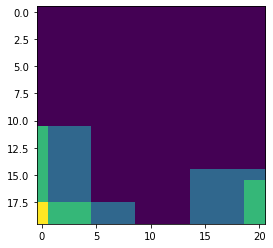

In [65]:
plt.imshow(K)

In [92]:
from sklearn.utils import shuffle
shuffled = shuffle(divs['tij'])

In [93]:
shuffled

13    -5
19    12
20   -14
15   -10
22    -9
23    14
7      7
8     13
10     8
14     7
11    14
3      5
2    -13
9     -9
18     9
21    -9
5      7
0      4
6     13
1     14
24    -2
17   -12
25     1
16    13
12     9
4    -10
Name: tij, dtype: int64

In [97]:
from numpy.random import permutation

In [98]:
tau_ = range(0,1000)
for tau in tau_:
    shuffled = 0
    ### create len(tau_) number of time permutations
    shuffled = divs['tij'].iloc[permutation(divs.index)]
    divs[f'tpi τ = {tau}'] = shuffled #divs['tij'].sample(frac=1)#.reset_index(drop = True)

In [99]:
divs

,index,x,y,t,tij,dij,tpi τ = 0,tpi τ = 1,tpi τ = 2,tpi τ = 3,...,tpi τ = 990,tpi τ = 991,tpi τ = 992,tpi τ = 993,tpi τ = 994,tpi τ = 995,tpi τ = 996,tpi τ = 997,tpi τ = 998,tpi τ = 999
0,94,843.819458,61.680279,878,4,947,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1,102,1180.294312,669.930969,888,14,369,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
2,181,621.644653,1162.725830,861,-13,418,-13,-13,-13,-13,...,-13,-13,-13,-13,-13,-13,-13,-13,-13,-13
3,208,825.678040,850.783081,879,5,230,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,239,183.474686,179.331772,864,-10,1157,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
5,248,656.802002,916.012939,881,7,357,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
6,267,68.129097,1095.888184,887,13,942,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
7,269,1065.861694,613.927551,881,7,385,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
8,270,689.722656,254.121933,887,13,805,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
9,294,967.867249,830.442566,865,-9,168,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
